In [1]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
aggr.counts <- Read10X("Hypertrophic_heart_CR6_no_norm/filtered_feature_bc_matrix")

aggr.seurat <- CreateSeuratObject(aggr.counts, min.cells = 10, min.features = 100, project = "Hypertrophic heart")

sample <- colnames(aggr.seurat) 
sample <- sub(".*-(\\d)", "\\1", sample)
sample.names <- plyr::mapvalues(sample, from = as.character(seq(1,5)), 
                                to = c("S3005", "S3011", "S3013", "S3015", "S3018"))
table(sample.names)
aggr.seurat$Sample <- sample.names

sample.names
S3005 S3011 S3013 S3015 S3018 
10643 15956  4192  9958  7097 

# Integration

Here we will run the Seurat integration pipeline on the individual samples

In [3]:
dataset.list <- SplitObject(aggr.seurat, split.by = "Sample")

remove(aggr.seurat)

dataset.list <- lapply(X = dataset.list, FUN = function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, nfeatures = 2000)
  return(x)
})

int.features <- SelectIntegrationFeatures(object.list = dataset.list, nfeatures = 2000)

heart.anchors <- FindIntegrationAnchors(object.list = dataset.list, 
                                        anchor.features = int.features,
                                        normalization.method = "LogNormalize")
heart.combined.seurat <- IntegrateData(anchorset = heart.anchors)

DefaultAssay(heart.combined.seurat) <- "integrated"

remove(heart.anchors)
remove(dataset.list)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23387 anchors

Filtering anchors

	Retained 5761 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13056 anchors

Filtering anchors

	Retained 6323 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14743 anchors

Filtering anchors

	Retained 5570 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20226 anchors

Filtering anchors

	Retained 7325 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 27727 anchors

Filtering anchors

	Retained 6936 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13741 anchors

Filtering anchors

	Retained 4530 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17008 anchors

Filtering anchors

	Retained 

In [4]:
# Run clustering on the integrated data
heart.combined.seurat <- ScaleData(heart.combined.seurat)
heart.combined.seurat <- RunPCA(heart.combined.seurat, verbose = FALSE)
heart.combined.seurat <- RunUMAP(heart.combined.seurat, reduction = "pca", dims = 1:50)

heart.combined.seurat <- FindNeighbors(heart.combined.seurat, reduction = "pca", dims = 1:50)
heart.combined.seurat <- FindClusters(heart.combined.seurat, resolution = 0.8)

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:43:04 UMAP embedding parameters a = 0.9922 b = 1.112

22:43:04 Read 47846 rows and found 50 numeric columns

22:43:04 Using Annoy for neighbor search, n_neighbors = 30

22:43:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:43:08 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmpuw3nJR/file7d5627abb810

22:43:08 Searching Annoy index using 1 thread, search_k = 3000

22:43:20 Annoy recall = 100%

22:43:20 Com

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 47846
Number of edges: 2267503

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8932
Number of communities: 24
Elapsed time: 12 seconds


3 singletons identified. 21 final clusters.



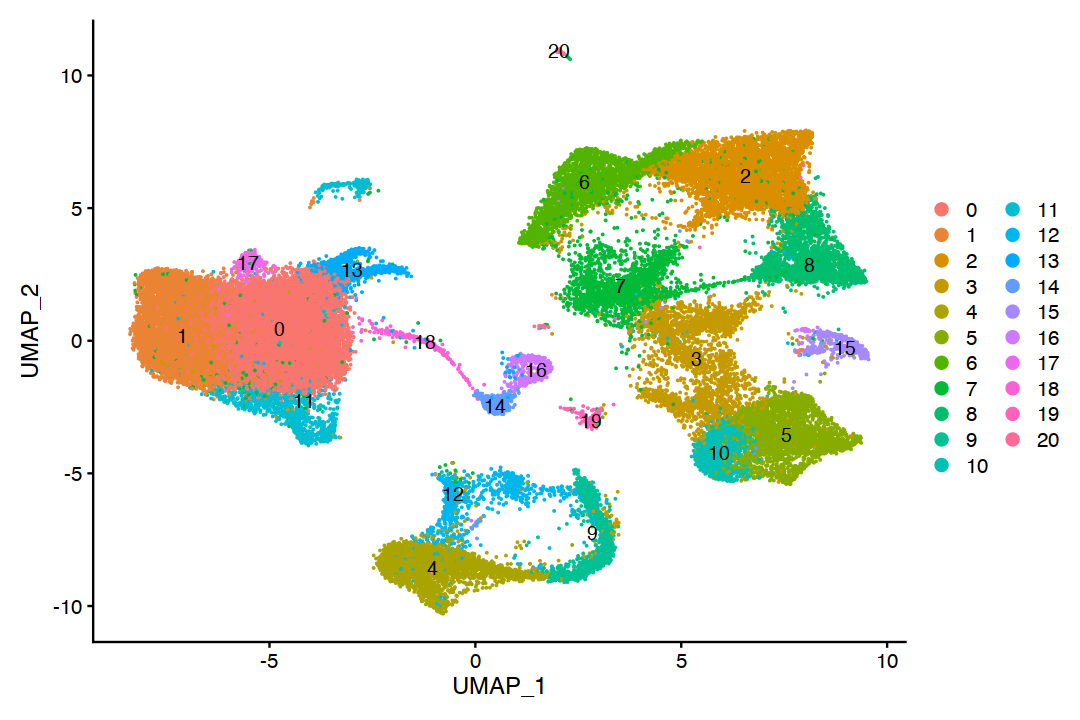

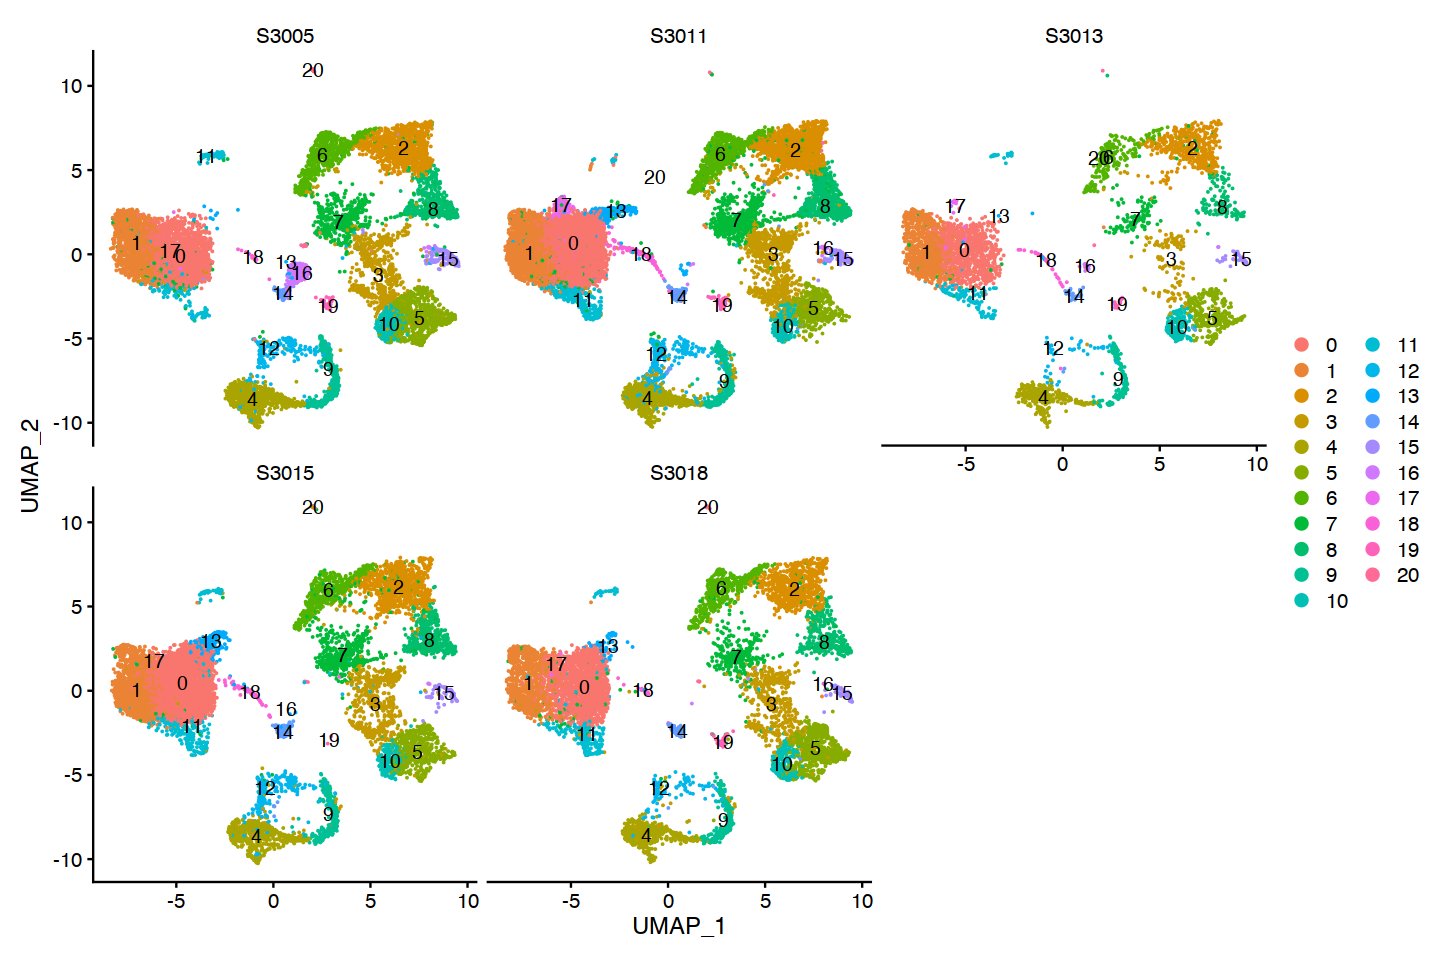

In [5]:
options(repr.plot.width=9, repr.plot.height=6)
DimPlot(heart.combined.seurat, label = TRUE)
options(repr.plot.width=12, repr.plot.height=8)
DimPlot(heart.combined.seurat, label = TRUE, split.by = "Sample", ncol = 3)

# Filter out doublets

[1] 44066

[1] 3795

[1] 44051


Doublet Singlet 
   3795   44051 

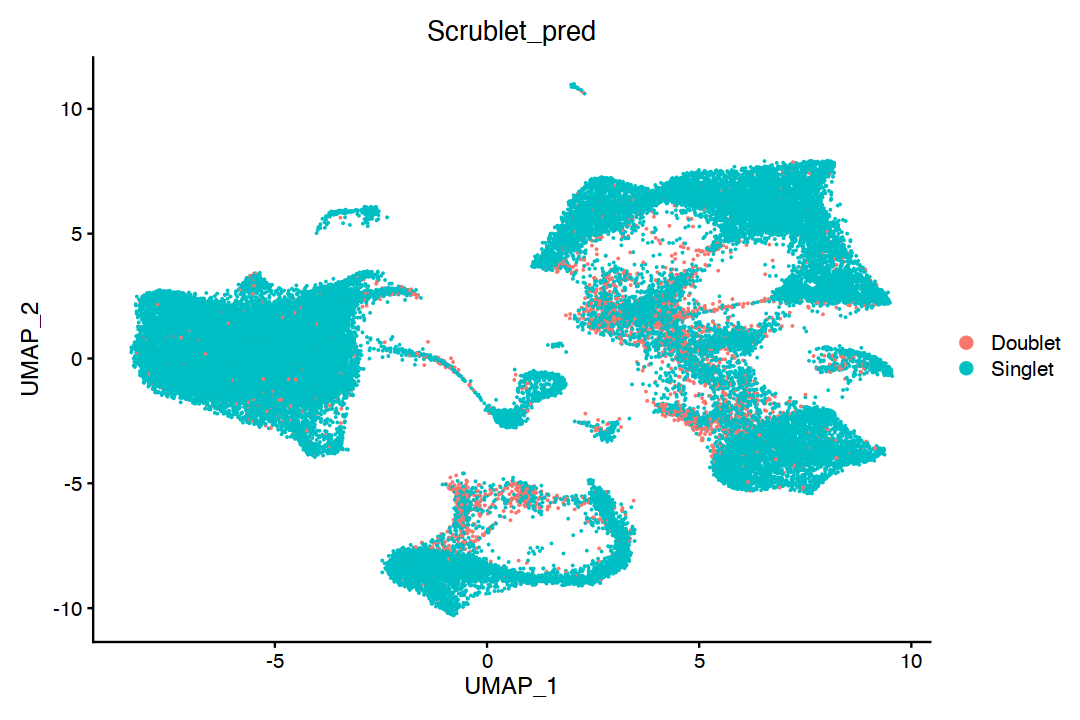

In [6]:
 ## Read in singlets identified with Scrublet
singlet.files <- c("Scrublet/S3005_singlets.txt",
                   "Scrublet/S3011_singlets.txt",
                   "Scrublet/S3013_singlets.txt",
                   "Scrublet/S3015_singlets.txt",
                   "Scrublet/S3018_singlets.txt")

all.singlets <- c()
for (this.file in singlet.files) {
  singlets <- readLines(this.file)
  all.singlets <- append(all.singlets, singlets)
}
length(all.singlets)

length(setdiff(colnames(heart.combined.seurat), all.singlets))
length(intersect(colnames(heart.combined.seurat), all.singlets))

scrublet.doublet <- ifelse(colnames(heart.combined.seurat) %in% all.singlets, "Singlet", "Doublet")
heart.combined.seurat@meta.data$Scrublet_pred <- scrublet.doublet

table(heart.combined.seurat$Scrublet_pred)

options(repr.plot.width=9, repr.plot.height=6)
DimPlot(heart.combined.seurat, group.by = "Scrublet_pred")

[1]  2000 44051

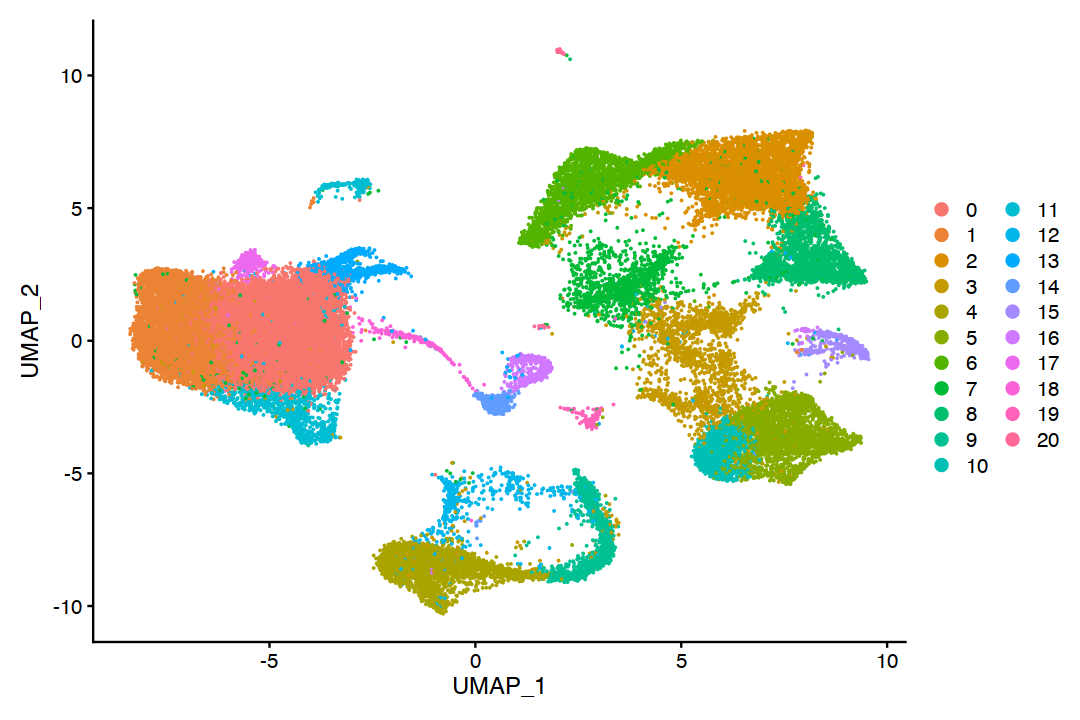

In [7]:
## Filter Seurat object for singlets
heart.combined.seurat <- subset(heart.combined.seurat, Scrublet_pred == "Singlet")
dim(heart.combined.seurat)
DimPlot(heart.combined.seurat)

In [8]:
table(heart.combined.seurat$Sample)


S3005 S3011 S3013 S3015 S3018 
10297 12906  4131  9757  6960 

In [9]:
## Re-run integration and clustering on singlets
DefaultAssay(heart.combined.seurat) <- "RNA"

dataset.list <- SplitObject(heart.combined.seurat, split.by = "Sample")

## Run log-normalization
dataset.list <- lapply(X = dataset.list, FUN = function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, nfeatures = 2000)
  return(x)
})

int.features <- SelectIntegrationFeatures(object.list = dataset.list, nfeatures = 2000)

heart.anchors <- FindIntegrationAnchors(object.list = dataset.list, 
                                        anchor.features = int.features,
                                        normalization.method = "LogNormalize")
heart.combined.seurat <- IntegrateData(anchorset = heart.anchors)

remove(heart.anchors)
remove(dataset.list)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21737 anchors

Filtering anchors

	Retained 5192 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12866 anchors

Filtering anchors

	Retained 6169 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13958 anchors

Filtering anchors

	Retained 4862 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19593 anchors

Filtering anchors

	Retained 6993 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 25838 anchors

Filtering anchors

	Retained 6258 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13672 anchors

Filtering anchors

	Retained 4487 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16638 anchors

Filtering anchors

	Retained 

In [10]:
DefaultAssay(heart.combined.seurat) <- "integrated"

heart.combined.seurat <- ScaleData(heart.combined.seurat)
heart.combined.seurat <- RunPCA(heart.combined.seurat, verbose = FALSE)
heart.combined.seurat <- RunUMAP(heart.combined.seurat, reduction = "pca", dims = 1:50)

heart.combined.seurat <- FindNeighbors(heart.combined.seurat, reduction = "pca", dims = 1:50)
heart.combined.seurat <- FindClusters(heart.combined.seurat, resolution = seq(0.2, 1.0, 0.2))

Centering and scaling data matrix

23:27:00 UMAP embedding parameters a = 0.9922 b = 1.112

23:27:00 Read 44051 rows and found 50 numeric columns

23:27:00 Using Annoy for neighbor search, n_neighbors = 30

23:27:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:27:04 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmpuw3nJR/file7d563d5d6fd7

23:27:04 Searching Annoy index using 1 thread, search_k = 3000

23:27:15 Annoy recall = 100%

23:27:15 Commencing smooth kNN distance calibration using 1 thread

23:27:17 Initializing from normalized Laplacian + noise

23:27:18 Commencing optimization for 200 epochs, with 2156068 positive edges

23:27:41 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 44051
Number of edges: 2082344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9579
Number of communities: 16
Elapsed time: 9 seconds


2 singletons identified. 14 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 44051
Number of edges: 2082344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9327
Number of communities: 18
Elapsed time: 10 seconds


2 singletons identified. 16 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 44051
Number of edges: 2082344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9098
Number of communities: 23
Elapsed time: 9 seconds


2 singletons identified. 21 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 44051
Number of edges: 2082344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8920
Number of communities: 24
Elapsed time: 10 seconds


2 singletons identified. 22 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 44051
Number of edges: 2082344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8773
Number of communities: 27
Elapsed time: 9 seconds


2 singletons identified. 25 final clusters.



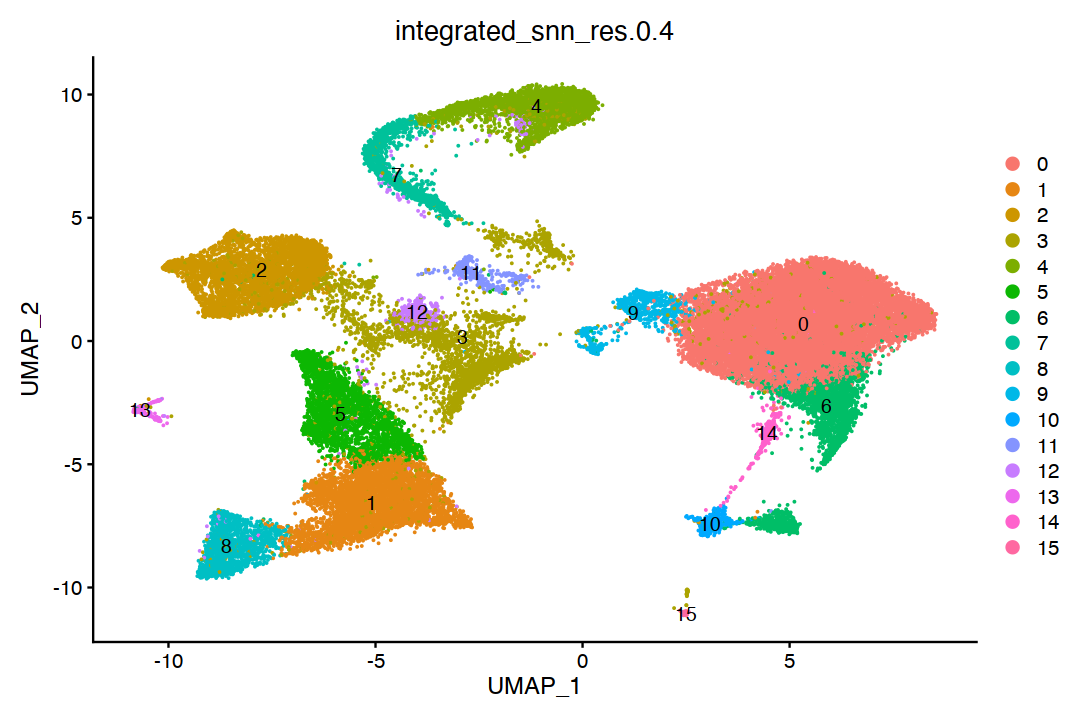

In [11]:
options(repr.plot.width=9, repr.plot.height=6)
heart.combined.seurat$integrated_snn_res.0.4 <- factor(heart.combined.seurat$integrated_snn_res.0.4, 
                                                       levels = as.character(seq(0, 15)))
DimPlot(heart.combined.seurat, label = TRUE, group.by = "integrated_snn_res.0.4")

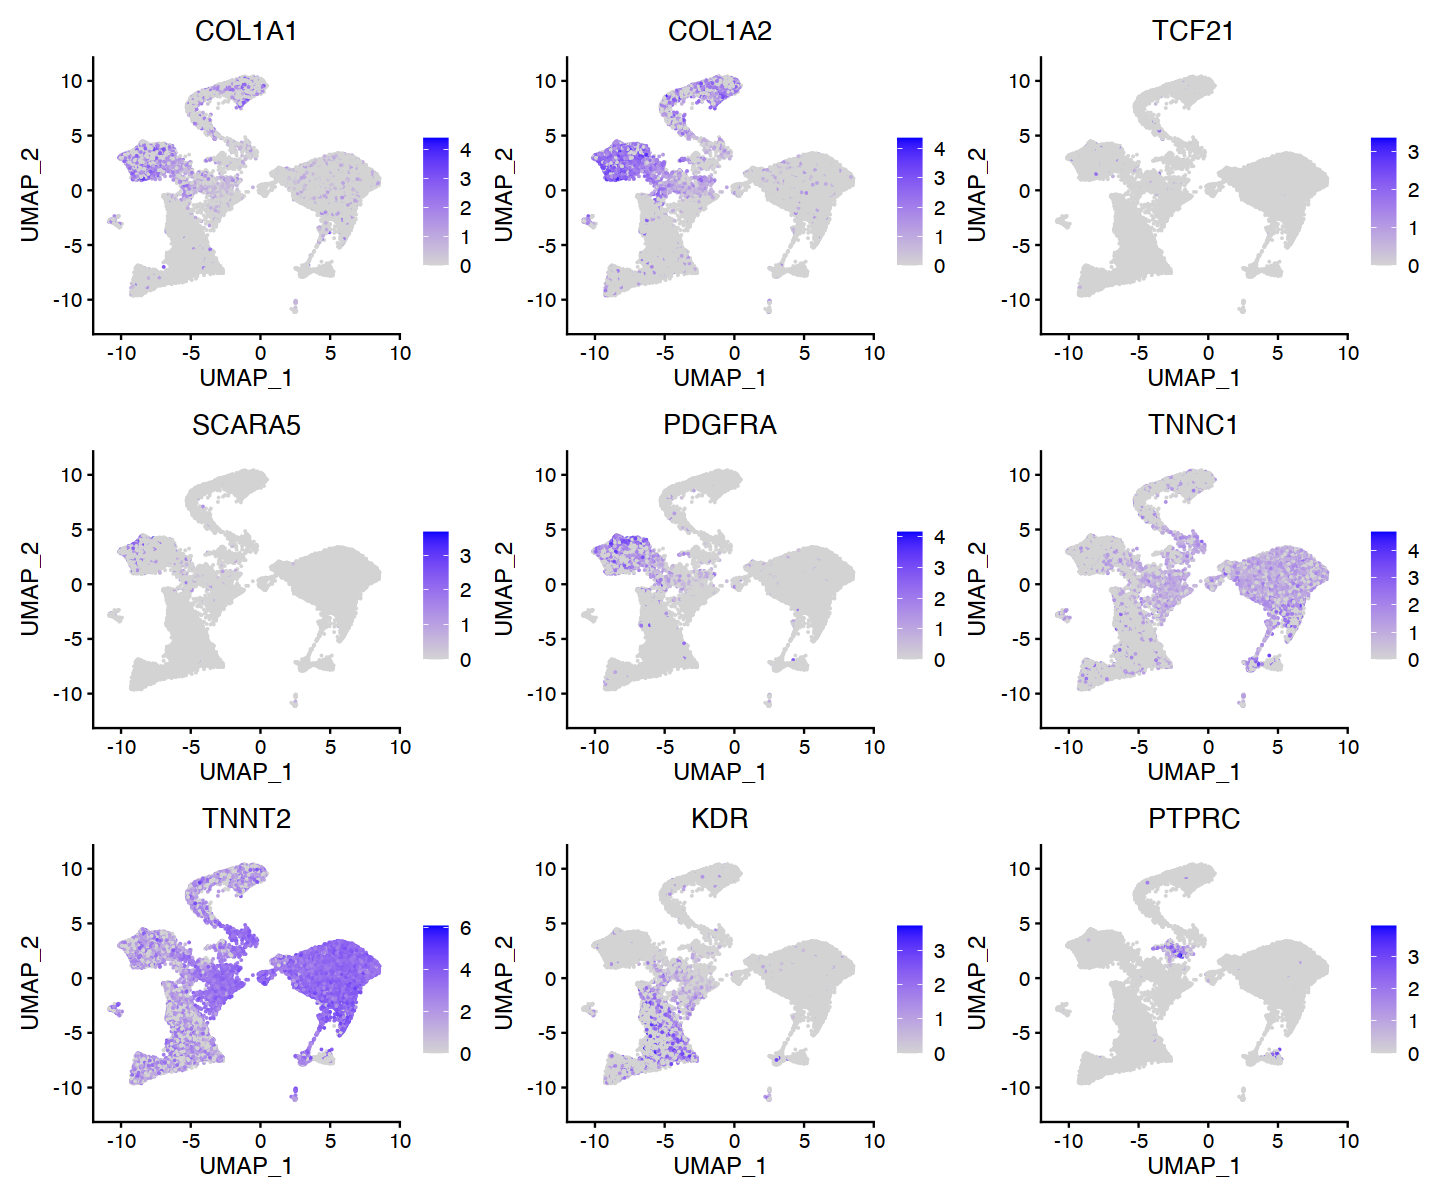

In [12]:
DefaultAssay(heart.combined.seurat) <- "RNA"
options(repr.plot.width=12, repr.plot.height=10)
FeaturePlot(heart.combined.seurat, c("COL1A1", "COL1A2", "TCF21", "SCARA5",
                                     "PDGFRA", "TNNC1", "TNNT2", "KDR", "PTPRC"))

# Select fibroblasts

In [13]:
Idents(heart.combined.seurat) <- heart.combined.seurat$integrated_snn_res.0.4
fibroblasts.integrated <- subset(heart.combined.seurat, ident = c( "2" ))

DefaultAssay(fibroblasts.integrated) <- "integrated"
fibroblasts.integrated <- RunPCA(fibroblasts.integrated, verbose = FALSE)
fibroblasts.integrated <- RunUMAP(fibroblasts.integrated, reduction = "pca", dims = 1:40)

fibroblasts.integrated <- FindNeighbors(fibroblasts.integrated, reduction = "pca", dims = 1:40)
fibroblasts.integrated <- FindClusters(fibroblasts.integrated, resolution = c(0.2, 0.3, 0.4, 0.5))

Idents(fibroblasts.integrated) <- fibroblasts.integrated$integrated_snn_res.0.5
Idents(fibroblasts.integrated) <- as.factor(as.integer(Idents(fibroblasts.integrated)))

23:28:54 UMAP embedding parameters a = 0.9922 b = 1.112

23:28:54 Read 4087 rows and found 40 numeric columns

23:28:54 Using Annoy for neighbor search, n_neighbors = 30

23:28:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:28:54 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmpuw3nJR/file7d561b2cd895

23:28:54 Searching Annoy index using 1 thread, search_k = 3000

23:28:55 Annoy recall = 100%

23:28:55 Commencing smooth kNN distance calibration using 1 thread

23:28:56 Initializing from normalized Laplacian + noise

23:28:56 Commencing optimization for 500 epochs, with 197662 positive edges

23:29:01 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4087
Number of edges: 290394

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8659
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4087
Number of edges: 290394

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8344
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4087
Number of edges: 290394

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8063
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4087
Number of edges: 290394

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7836
Number of communities: 5
Elapsed time: 0 seconds


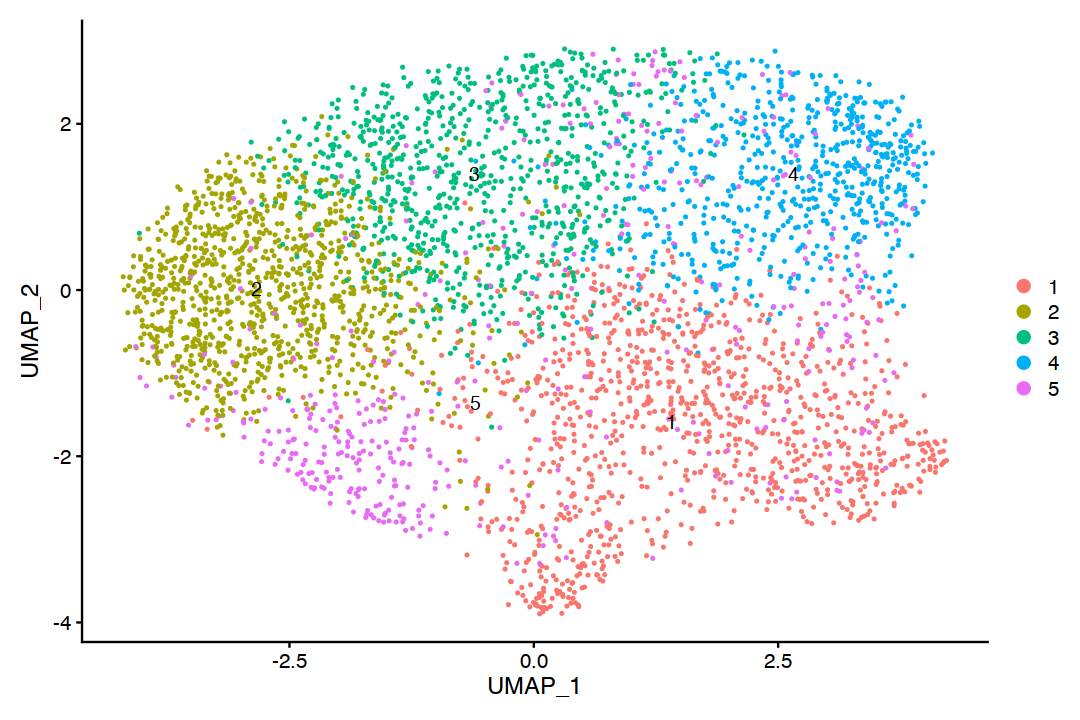

In [14]:
options(repr.plot.width=9, repr.plot.height=6)
DimPlot(fibroblasts.integrated, label = TRUE)

# Session information

In [15]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Matrix_1.3-4       dplyr_1.0.7        plyr_1.8.6         SeuratObject_4.0.2
[5] Seurat_4.0.3       ggplot2_3.3.5     

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 matrixStats_0.60.0   
  [4] RcppAnnoy_0.0.19      RColorBrewer_1.1-2    httr_1.4.2           
  [7] repr_1.1.3            sctransform_0.3.2     tools_4.1.0          
 [10] utf8_1.2.2            R6_2.5.0              irlba_2.3.3          
 [13] rpart_4.1-15          KernSmooth_2.23-20 